# **Printed Circuit Board defects**
**PCB Defects** are of 6 types-
1. **spurious copper**
2. **spur** 
3. **mousebite** 
4. **pin hole** 
5. **short circuit** 
6. **open circuit**

![Defects in PCB](http://www.researchgate.net/profile/Alexandr-Doudkin/publication/228451936/figure/fig1/AS:669451984834564@1536621199438/Example-of-a-PCB-layout-defects-1-spurious-copper-2-spur-3-mousebit-4-pin-hole_W640.jpg)
Image taken from [ResearchGate Article](https://www.researchgate.net/publication/228451936_Computeraided_technique_for_defect_and_project_rules_inspection_on_PCB_layout_image)



Let us look at some of these defects and train a model to idenify them for us.

In [1]:
!pip install keras-cv
!pip install pycocotools
!pip install split-folders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373763 sha256=2cb350307bf80c74730e5889fffdc9f2ed7c6b25cfab85f49c84ddc337b3957a
  Stored in directory: /root/.cache/pip/wheels/d0/90/d4/e9ae0a3cdbd8e0cddf6b5fe8c31774fb9bd0ae4e9754fb2314
Successfully built pycocotools


In [2]:
import keras_cv
import tensorflow as tf
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import keras
import cv2

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


# The dataset

The dataset we will use for this tutorial is the [PCB defects dataset](https://www.kaggle.com/datasets/akhatova/pcb-defects) available on Kaggle. The dataset has some good quality, close up images of the above mentioned PCB defects. The images are stored in their respective directories as per their labels.


We will first download these images to our woking directory and then split them into a train,tes,val datasets using **split-folders** an OpenSourced tool for directory level data split.

In [3]:
os.mkdir('images')
os.chdir(os.path.join(os.getcwd(),'images'))

In [4]:
path_to_img='/kaggle/input/pcb-defects/PCB_DATASET/images'
import splitfolders
input_folder =path_to_img
output='/kaggle/working/images'
splitfolders.ratio(input_folder, output=output, ratio=(.6, .2, .2))

Copying files: 693 files [00:13, 50.92 files/s]


In [5]:
image_dir=os.getcwd()
print(image_dir)
print('directories in images are')
print(os.listdir())

/kaggle/working/images
directories in images are
['train', 'val', 'test']


# Loading a custom datset into TFDS 

[An article](https://towardsdatascience.com/youre-importing-data-wrong-c171f52eea00) on Tensorflow Datasets reads:-

> Extract,Transform and Load (ETL) the data to use it in your Machine Learning Model for training and testing.
>
> This ETL approach is common to all Data Pipelines, and the ML Pipeline is no exception.
>
> Doing these steps using individual frameworks can be tedious, which is exactly where TensorFlow Datasets or TFDS and the tf.data module fit in. Let’s see how!

**The Tensorflow datasets(TFDS)** have extensive support within Tensorflow and Keras, making it the obvious choice when working with these packages for CV. TensorFlow has a collection of ready-to-use datasets known as the **TF datasets** but it is also possible to load a custom dataset into the TFDS format.

**Steps:-**
1. **Import tensorflow_datasets**
2. **Create an ImageFolder object and pass the directory of the dataset as the parameter**
    >ImageFolder creates a tf.data.Dataset reading the original image files.
3. **Use the builder.as_Dataset method to construct a tf.data.Dataset**
    >Callers must pass arguments as keyword arguments.
    >
    >The output types vary depending on the parameters. Specify the split as either "train", "test", "val"

That's it. You have loaded a custom dataset into a TFDS :) 

Did you know that when you use a dataset from the TFDS list using *tfds.load()*, it internaly uses a builder similar to ours to *download_and_prepare* the data and then loads it up as a dataset.

**We can also see the images in the dataset using "tfds.show_examples(dataset,builder_info)"**

In [6]:
#Steps 2
builder = tfds.ImageFolder(image_dir)
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=6),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=141, num_shards=1>,
        'train': <SplitInfo num_examples=414, num_shards=1>,
        'val': <SplitInfo num_examples=138, num_shards=1>,
    },
    citation="""""",
)


In [7]:
#Step 3
images_train = builder.as_dataset(split='train',as_supervised=True)
images_test =  builder.as_dataset(split='test',as_supervised=True)
images_val = builder.as_dataset(split='val',as_supervised=True)

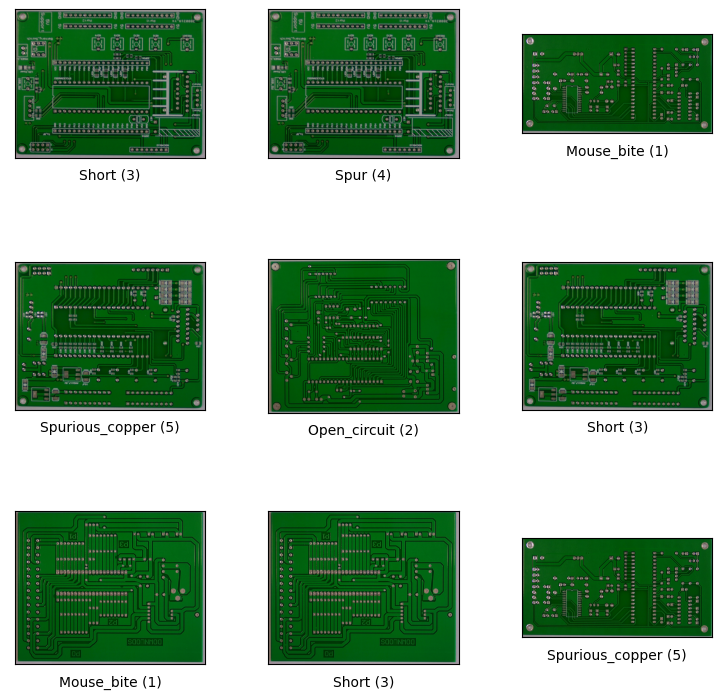

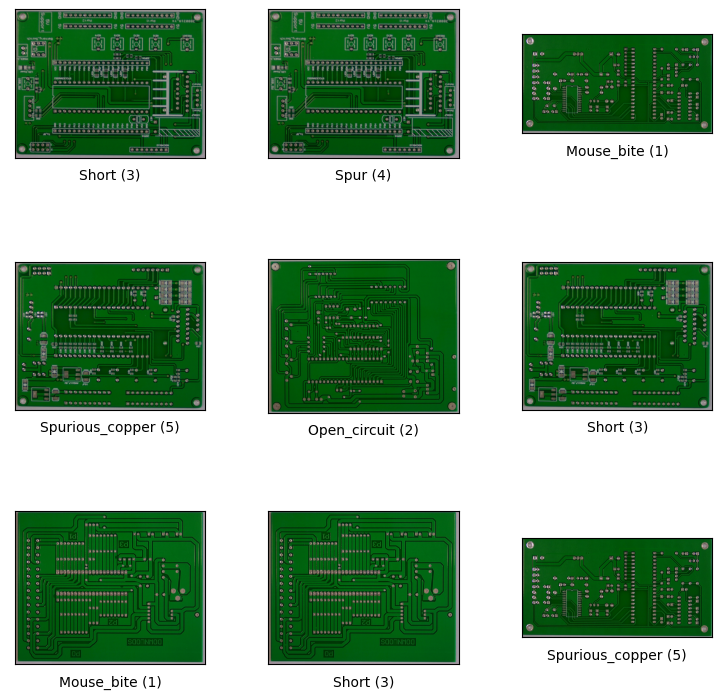

In [8]:
tfds.show_examples(images_train, builder.info)

In [9]:
#A function to perform the necessary data preprocessing steps 
def prepare_data(images, labels):
    labels = tf.one_hot(labels,6)
    images = tf.image.resize(images, (1500, 1500))
    images=tf.image.convert_image_dtype(images, tf.float32)
    print('conversions done')
    inputs = {"images": images, "labels": labels}
    return inputs

In [10]:
images_train = images_train.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
images_test = images_test.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
images_val = images_val.map(prepare_data, num_parallel_calls=tf.data.AUTOTUNE).batch(1)

conversions done
conversions done
conversions done


# Augmentation

Let's Augment the dataset using Keras_CV.

Let us begin by defining an Augmenter

In [11]:
augmenter=keras_cv.layers.Augmenter(
  layers=[
      keras_cv.layers.RandomFlip(),
      keras_cv.layers.RandomChannelShift((0,255),0.5),
      keras_cv.layers.RandomColorJitter((0,255),(-0.2, 0.5),(0.5, 0.9),(0.5, 0.9),(0.5, 0.9)),
      keras_cv.layers.RandomBrightness(0.15),
    ]
)

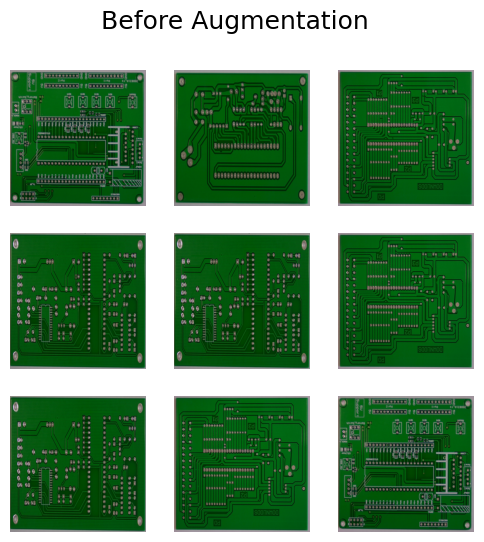

In [12]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
visualize_dataset(images_train, title="Before Augmentation")

In [13]:
images_train_aug = images_train.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
images_test_aug = images_test.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
images_val_aug = images_val.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

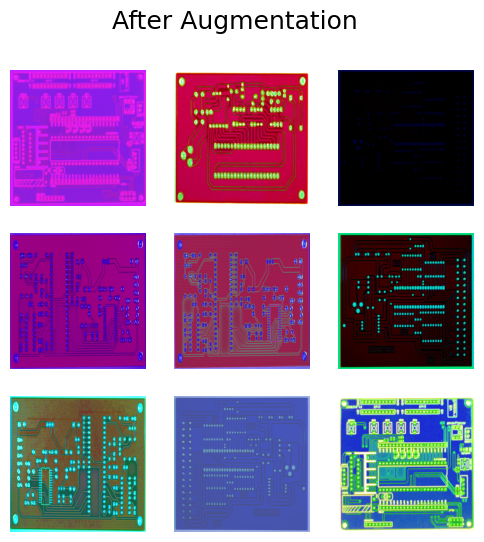

In [14]:
visualize_dataset(images_train_aug, title="After Augmentation")

In [15]:
effnet = keras_cv.models.EfficientNetV2B1(include_rescaling=False,
                                          include_top=False,
                                          input_shape=(1500, 1500, 3),
                                          weights="imagenet/classification-v0")
effnet.trainable=False
model=tf.keras.models.Sequential()
model.add(keras.Input(shape=(1500, 1500, 3)))
model.add(effnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(6))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

28156960/28156960 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 47, 47, 1280)      6931124   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 6,938,810
Trainable params: 7,686
Non-trainable params: 6,931,124
_________________________________________________________________


In [16]:
def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

In [17]:
def prep_for_model_val(inputs):
    images = inputs["images"]
    images = tf.cast(images, tf.float32)
    return images

In [18]:
train_dataset=images_train.map(prep_for_model)
test_dataset=images_test.map(prep_for_model)
val_dataset=images_val.map(prep_for_model)

In [19]:
callbacks=tf.keras.callbacks.EarlyStopping(min_delta=0.0005,patience=3)
history=model.fit(train_dataset,validation_data=test_dataset,epochs=30,callbacks=[callbacks])

Epoch 1/30


2023-04-02 05:04:24.098054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/model/block1b_/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


26/26 [==============================] - 54s 1s/step - loss: 6.9128 - accuracy: 0.1618 - val_loss: 6.0277 - val_accuracy: 0.1560
Epoch 2/30
26/26 [==============================] - 34s 1s/step - loss: 6.5281 - accuracy: 0.1643 - val_loss: 5.1648 - val_accuracy: 0.1560
Epoch 3/30
26/26 [==============================] - 37s 1s/step - loss: 5.8070 - accuracy: 0.1498 - val_loss: 4.1691 - val_accuracy: 0.1631
Epoch 4/30
26/26 [==============================] - 37s 1s/step - loss: 6.1650 - accuracy: 0.1425 - val_loss: 3.6305 - val_accuracy: 0.1773
Epoch 5/30
26/26 [==============================] - 36s 1s/step - loss: 7.1409 - accuracy: 0.1618 - val_loss: 10.2744 - val_accuracy: 0.1702
Epoch 6/30
26/26 [==============================] - 35s 1s/step - loss: 7.8156 - accuracy: 0.1473 - val_loss: 7.9192 - val_accuracy: 0.1560
Epoch 7/30
26/26 [==============================] - 34s 1s/step - loss: 6.8336 - accuracy: 0.1787 - val_loss: 7.6214 - val_accuracy: 0.1631


<AxesSubplot:>

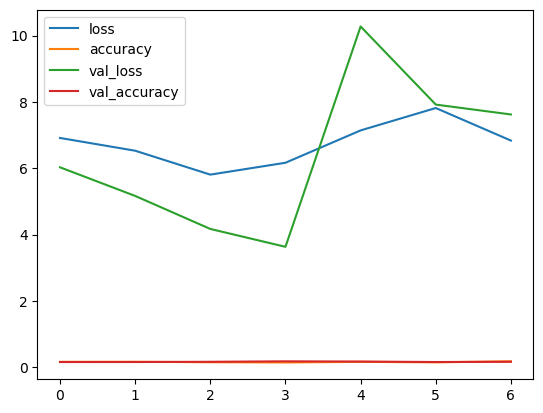

In [20]:
import pandas as pd
history=pd.DataFrame(history.history)
history.plot()

In [21]:
model.evaluate(val_dataset)

138/138 [==============================] - 11s 71ms/step - loss: 7.5480 - accuracy: 0.1667


[7.548012733459473, 0.1666666716337204]